In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from PIL import Image
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten

In [ ]:
! unzip "/content/gdrive/MyDrive/25K.zip" #
#! unzip "/content/gdrive/MyDrive/50K.zip" #

Streaming output truncated to the last 5000 lines.
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3938.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3939.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_394.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3940.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3949.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3954.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3957.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinoma_3964.png  
  inflating: NSCLC_Radiomics_50k_splitted2/validation/Large_cell_carcinoma/Large_cell_carcinom

In [ ]:
path = "/content/NSCLC_Radiomics_50k_splitted2" #25K
#path = "/content/NSCLC_Radiomics_50k_TTV" #50K + cost sensitive

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    f"{path}/train",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

test_ds = keras.utils.image_dataset_from_directory(
    f"{path}/test",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

val_ds = keras.utils.image_dataset_from_directory(
    f"{path}/validation",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

Found 10000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [ ]:
# Define the new image size
new_image_size = (75, 75)

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, new_image_size)
    return image, label

# Apply resizing to the datasets
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

In [ ]:
# Normalize the pixel values
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize pixel values
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# One-hot encode the labels
num_classes = 5  # Update with the actual number of classes
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
total_images = 51215
class_frequencies = {
    0: 6018,  # Adenocarcinoma
    1: 13655,  # Large_cell_carcinoma
    2: 5130,   # Normal
    3: 7643,   # Not_otherwise_specified
    4: 18769   # Squamous_cell_carcinoma
}

# Calculate class weights for imbalanced classes
class_weights = {}
total_samples = sum(class_frequencies.values())

for cls, num_samples in class_frequencies.items():
    weight = total_samples / (len(class_frequencies) * num_samples)
    class_weights[cls] = weight

print("Calculated Class Weights for Imbalanced Classes:", class_weights)

Calculated Class Weights for Imbalanced Classes: {0: 1.7020604852110335, 1: 0.7501281581838155, 2: 1.9966861598440546, 3: 1.3401805573727594, 4: 0.545740316479301}


In [ ]:
# Define misclassification costs for each class in your image dataset
false_positive_costs = [10, 5, 1, 5, 10]  # Example values for false positives
false_negative_costs = [1, 10, 10, 5, 1]  # Example values for false negatives

# Calculate class weights based on both false positives and false negatives
class_weights = [1 / (fp_cost + fn_cost) for fp_cost, fn_cost in zip(false_positive_costs, false_negative_costs)]

# Combine class weights based on misclassification costs with class frequencies
class_frequencies = {
    0: 6018,  # Adenocarcinoma
    1: 13655,  # Large_cell_carcinoma
    2: 5130,   # Normal
    3: 7643,   # Not_otherwise_specified
    4: 18769   # Squamous_cell_carcinoma
}

# Weight the class weights based on class frequencies
weighted_class_weights = [weight * (total_images / class_frequencies[class_id]) for class_id, weight in enumerate(class_weights)]

# Normalize the class weights (optional)
total_weight = sum(weighted_class_weights)
class_weights_normalized = [weight / total_weight for weight in weighted_class_weights]

print("Class Weights based on Misclassification Costs and Class Frequencies:", weighted_class_weights)
print("Normalized Class Weights:", class_weights_normalized)


Class Weights based on Misclassification Costs and Class Frequencies: [0.7736638569141061, 0.25004271939460515, 0.9075846181109338, 0.6700902786863798, 0.24806378021786407]
Normalized Class Weights: [0.2715138520424718, 0.0877513681313685, 0.31851274105099325, 0.2351651704501839, 0.08705686832498244]


In [ ]:
# Convert class weights to an array of float values

class_weights = {cls: weight for cls, weight in enumerate(class_weights_normalized)}
print(class_weights)

{0: 0.2715138520424718, 1: 0.0877513681313685, 2: 0.31851274105099325, 3: 0.2351651704501839, 4: 0.08705686832498244}


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Create a simple CNN model
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(75, 75, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(5, activation='softmax'))

# Display the model summary
cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               10616960  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [ ]:
from keras.applications import ResNet152V2
#Creating Models (Reducing dimentions and preventing Overfitting)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


for layer in base_model.layers:
    layer.trainable=True
resnet = Sequential()
resnet.add(base_model)
resnet.add(GaussianNoise(0.25))
resnet.add(GlobalAveragePooling2D())
resnet.add(Dense(1024,activation='relu'))
resnet.add(BatchNormalization())
resnet.add(GaussianNoise(0.25))
resnet.add(Dropout(0.25))
resnet.add(Flatten())
resnet.add(Dense(5, activation='softmax'))
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 gaussian_noise (GaussianNo  (None, 3, 3, 2048)        0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                      

In [ ]:
from keras.src.applications import VGG19

# Create the base VGG model with pre-trained weights
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Make the layers in the base model trainable
for layer in base_model_vgg.layers:
    layer.trainable = True

# Create the VGG model
vgg = Sequential()
vgg.add(base_model_vgg)
vgg.add(GaussianNoise(0.25))
vgg.add(GlobalAveragePooling2D())
vgg.add(Dense(1024, activation='relu'))
vgg.add(BatchNormalization())
vgg.add(GaussianNoise(0.25))
vgg.add(Dropout(0.25))
vgg.add(Flatten())
vgg.add(Dense(5, activation='softmax'))
vgg.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 gaussian_noise_2 (Gaussian  (None, 2, 2, 512)         0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                      

In [ ]:
#Creating Models (Reducing dimentions and preventing Overfitting)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


for layer in base_model.layers:
    layer.trainable=True
xception = Sequential()
xception.add(base_model)
xception.add(GaussianNoise(0.25))
xception.add(GlobalAveragePooling2D())
xception.add(Dense(1024,activation='relu'))
xception.add(BatchNormalization())
xception.add(GaussianNoise(0.25))
xception.add(Dropout(0.25))
xception.add(Flatten())
xception.add(Dense(5, activation='softmax'))
xception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 gaussian_noise_4 (Gaussian  (None, 3, 3, 2048)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                      

In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
cnn.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []
cnn_train_precisions = []
cnn_val_precisions = []
cnn_train_recalls = []
cnn_val_recalls = []
cnn_train_cosine_similarity = []
cnn_val_cosine_similarity = []

for epoch in range(200):
    # Train the model for one epoch
    #history = cnn.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = cnn.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    cnn_train_losses.append(history.history['loss'][0])
    cnn_val_losses.append(history.history['val_loss'][0])
    cnn_train_accuracies.append(history.history['categorical_accuracy'][0])
    cnn_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    cnn_train_precisions.append(history.history['precision'][0])
    cnn_val_precisions.append(history.history['val_precision'][0])
    cnn_train_recalls.append(history.history['recall'][0])
    cnn_val_recalls.append(history.history['val_recall'][0])
    cnn_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    cnn_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = cnn.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
cnn.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.

100/100 [==============================] - 5s 47ms/step - loss: 0.0095 - categorical_accuracy: 0.9978 - top_5_categorical_accuracy: 1.0000 - precision: 0.9978 - recall: 0.9978 - cosine_similarity: 0.9982 - val_loss: 0.2357 - val_categorical_accuracy: 0.9417 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9450 - val_recall: 0.9393 - val_cosine_similarity: 0.9488


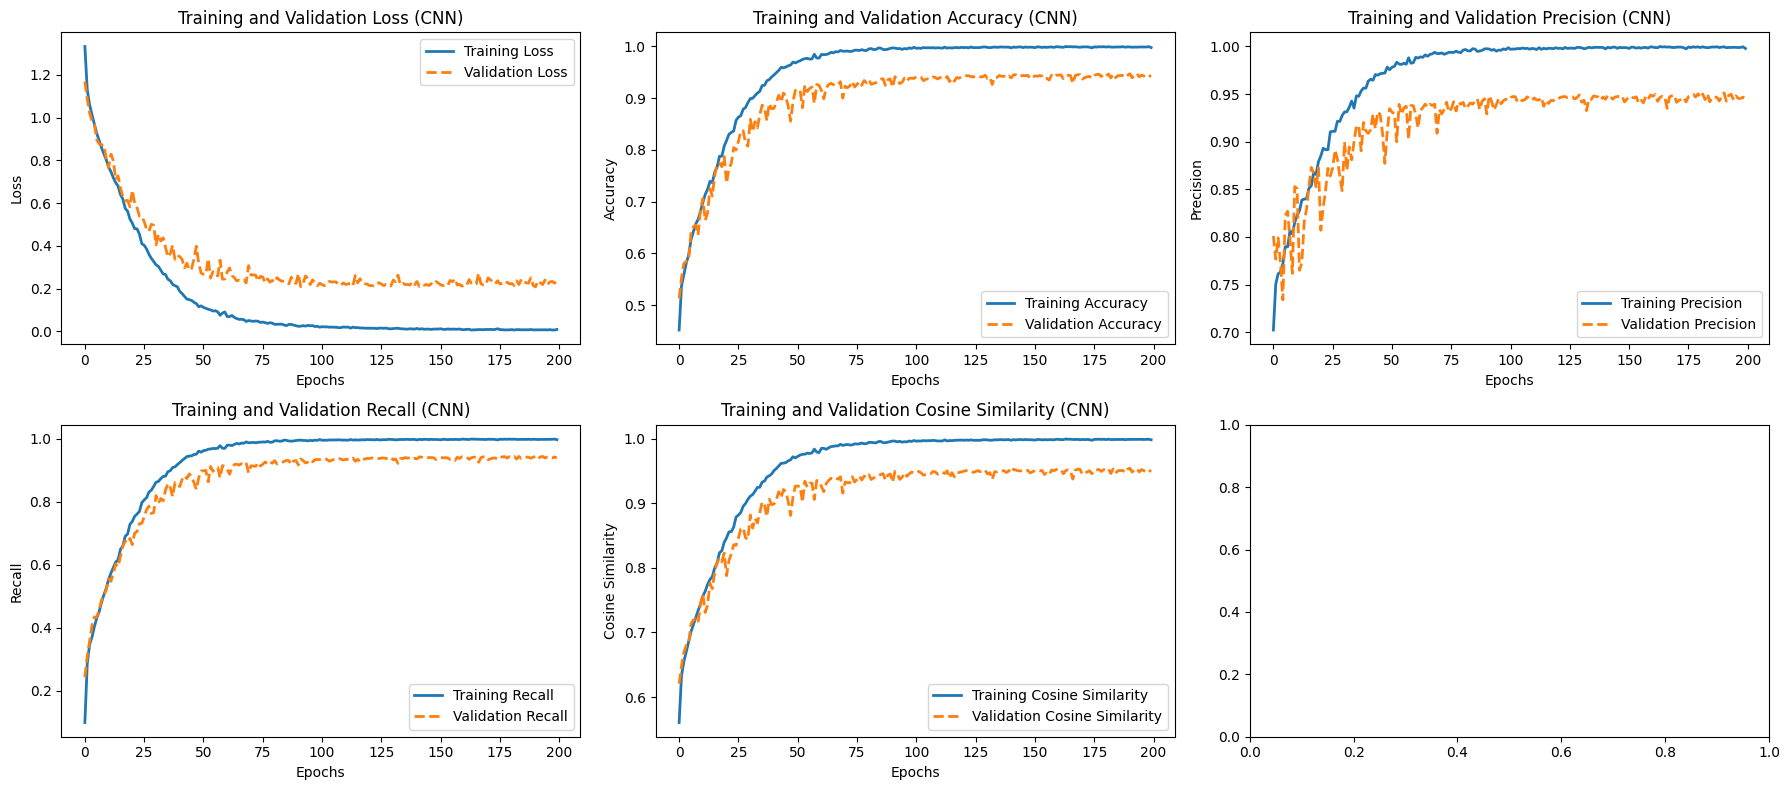

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(cnn_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(cnn_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (CNN)')

# Plot training and validation accuracy
axes[0, 1].plot(cnn_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(cnn_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (CNN)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(cnn_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(cnn_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (CNN)')

axes[1, 0].plot(cnn_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(cnn_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (CNN)')

axes[1, 1].plot(cnn_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(cnn_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (CNN)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Define early stopping callback for ResNet
early_stopping_resnet = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the ResNet model with additional metrics (Precision, Recall, and Cosine Similarity)
resnet.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),  # Precision
        tf.keras.metrics.Recall(name='recall'),  # Recall
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')  # Cosine Similarity
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights for ResNet
best_val_loss_resnet = float('inf')
best_weights_resnet = None

# Lists to store training and validation metrics for ResNet
resnet_train_losses = []
resnet_val_losses = []
resnet_train_accuracies = []
resnet_val_accuracies = []
resnet_train_precisions = []
resnet_val_precisions = []
resnet_train_recalls = []
resnet_val_recalls = []
resnet_train_cosine_similarity = []
resnet_val_cosine_similarity = []

for epoch in range(200):
    # Train the ResNet model for one epoch
    #history = resnet.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = resnet.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    resnet_train_losses.append(history.history['loss'][0])
    resnet_val_losses.append(history.history['val_loss'][0])
    resnet_train_accuracies.append(history.history['categorical_accuracy'][0])
    resnet_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    resnet_train_precisions.append(history.history['precision'][0])
    resnet_val_precisions.append(history.history['val_precision'][0])
    resnet_train_recalls.append(history.history['recall'][0])
    resnet_val_recalls.append(history.history['val_recall'][0])
    resnet_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    resnet_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far for ResNet
    if history.history['val_loss'][0] < best_val_loss_resnet:
        best_val_loss_resnet = history.history['val_loss'][0]
        best_weights_resnet = resnet.get_weights()

# After training, you can set the model weights to the best weights for ResNet
resnet.set_weights(best_weights_resnet)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists for ResNet.

100/100 [==============================] - 37s 374ms/step - loss: 3.3234e-05 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.2100 - val_categorical_accuracy: 0.9617 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9630 - val_recall: 0.9607 - val_cosine_similarity: 0.9647


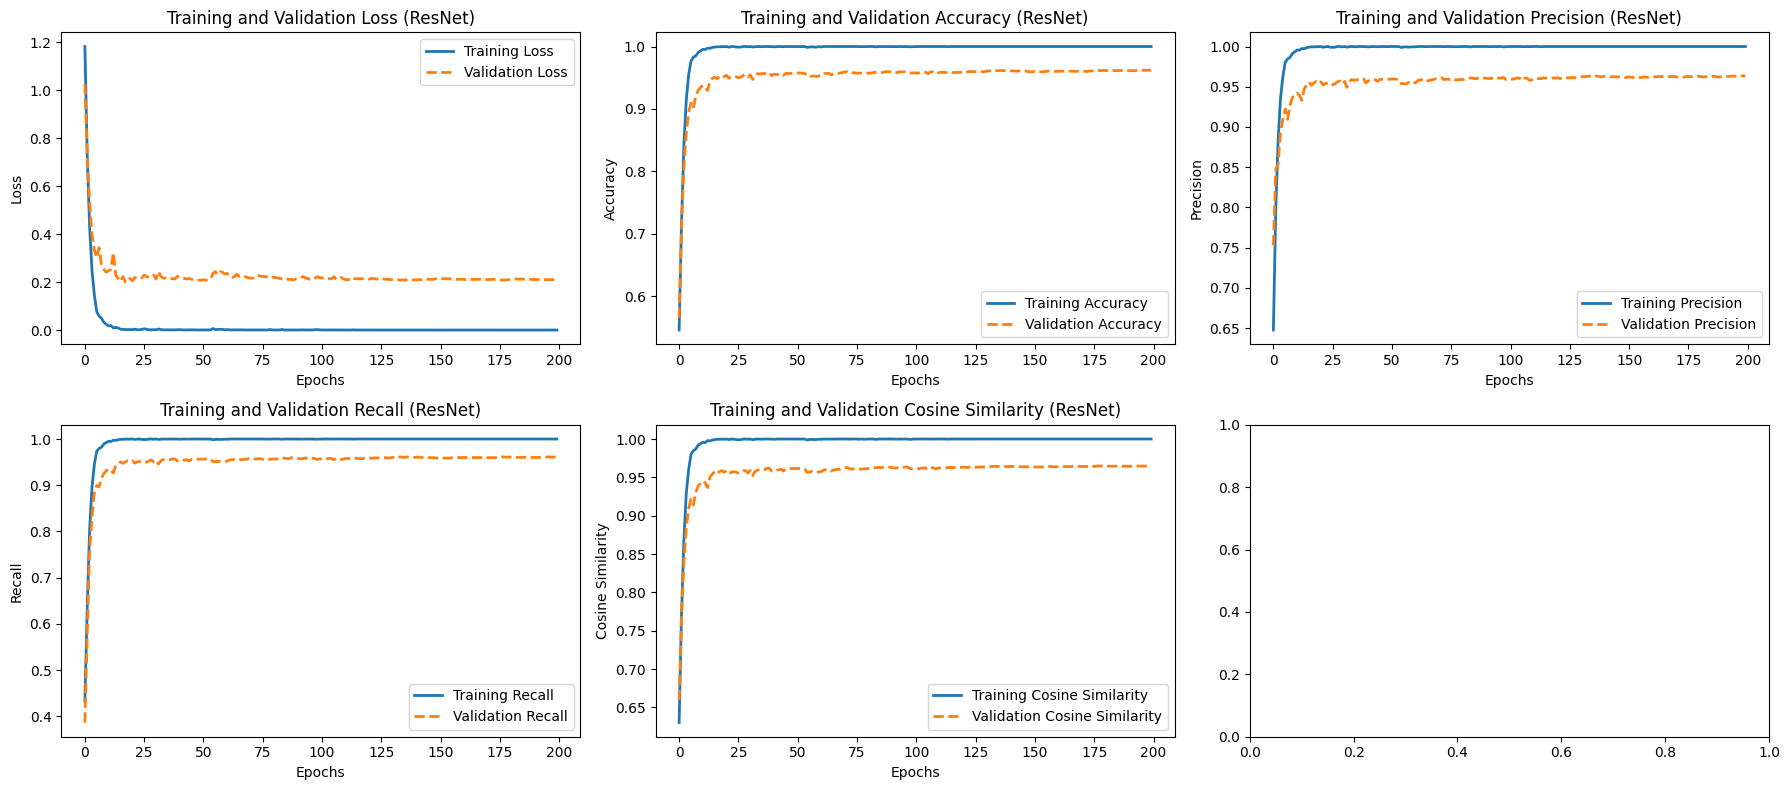

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(resnet_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(resnet_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (ResNet)')

# Plot training and validation accuracy
axes[0, 1].plot(resnet_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(resnet_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (ResNet)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(resnet_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(resnet_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (ResNet)')

axes[1, 0].plot(resnet_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(resnet_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (ResNet)')

axes[1, 1].plot(resnet_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(resnet_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (ResNet)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Define early stopping callback for VGG
early_stopping_vgg = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the VGG model with additional metrics (Precision, Recall, and Cosine Similarity)
vgg.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),  # Precision
        tf.keras.metrics.Recall(name='recall'),  # Recall
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')  # Cosine Similarity
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights for VGG
best_val_loss_vgg = float('inf')
best_weights_vgg = None

# Lists to store training and validation metrics for VGG
vgg_train_losses = []
vgg_val_losses = []
vgg_train_accuracies = []
vgg_val_accuracies = []
vgg_train_precisions = []
vgg_val_precisions = []
vgg_train_recalls = []
vgg_val_recalls = []
vgg_train_cosine_similarity = []
vgg_val_cosine_similarity = []

for epoch in range(200):
    # Train the VGG model for one epoch
    #history = vgg.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = vgg.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    vgg_train_losses.append(history.history['loss'][0])
    vgg_val_losses.append(history.history['val_loss'][0])
    vgg_train_accuracies.append(history.history['categorical_accuracy'][0])
    vgg_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    vgg_train_precisions.append(history.history['precision'][0])
    vgg_val_precisions.append(history.history['val_precision'][0])
    vgg_train_recalls.append(history.history['recall'][0])
    vgg_val_recalls.append(history.history['val_recall'][0])
    vgg_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    vgg_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far for VGG
    if history.history['val_loss'][0] < best_val_loss_vgg:
        best_val_loss_vgg = history.history['val_loss'][0]
        best_weights_vgg = vgg.get_weights()

# After training, you can set the model weights to the best weights for VGG
vgg.set_weights(best_weights_vgg)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists for VGG.

100/100 [==============================] - 20s 199ms/step - loss: 3.4380e-05 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.3006 - val_categorical_accuracy: 0.9471 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.9484 - val_recall: 0.9459 - val_cosine_similarity: 0.9516


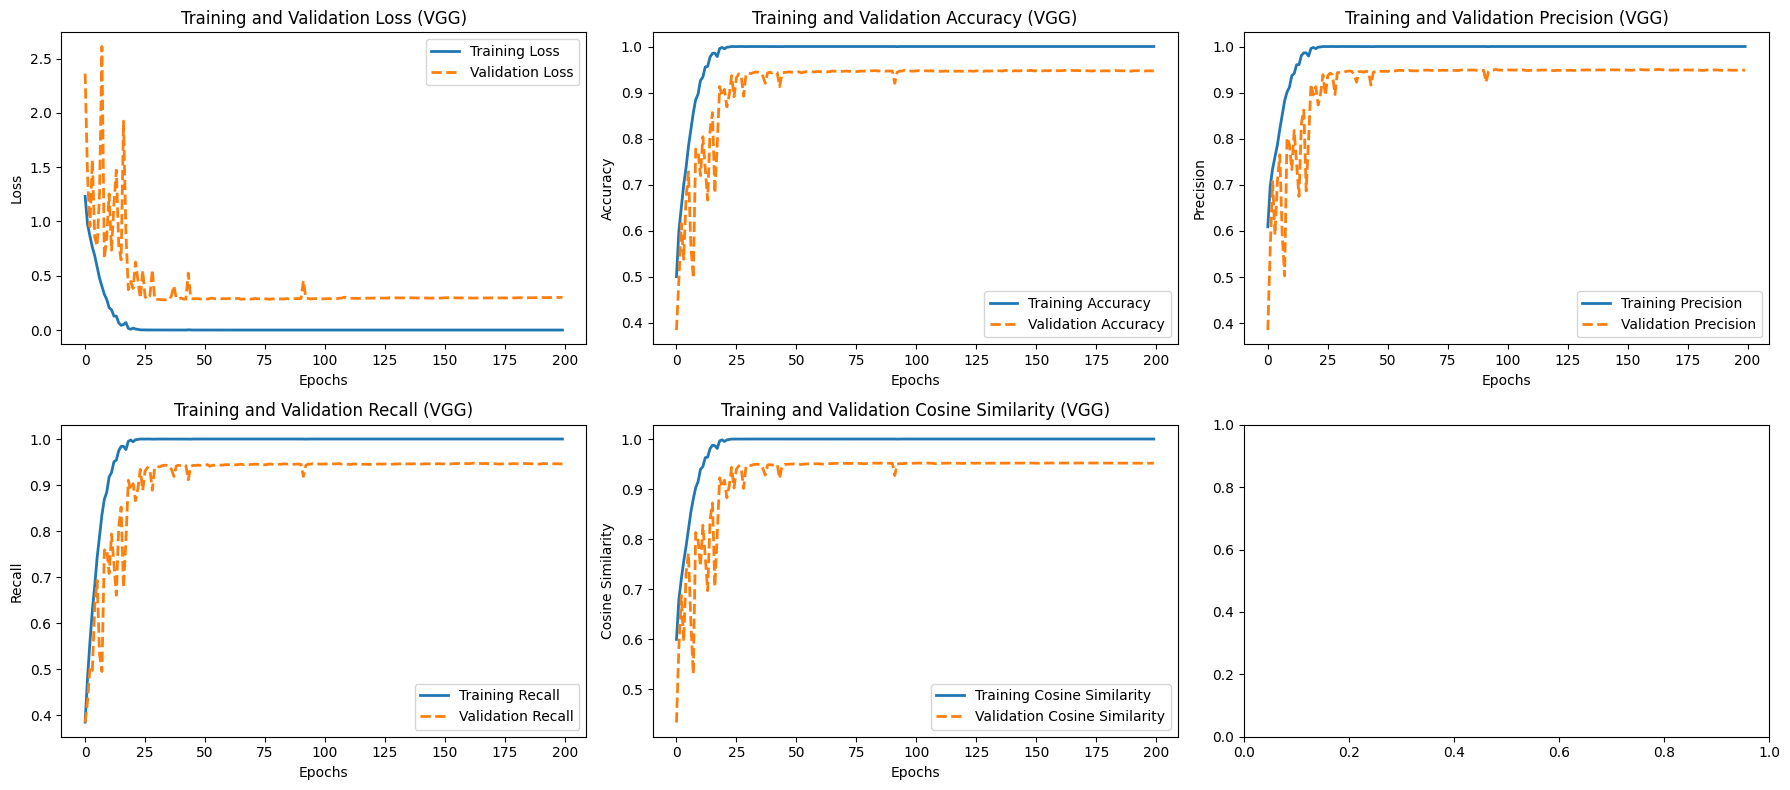

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(vgg_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(vgg_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (VGG)')

# Plot training and validation accuracy
axes[0, 1].plot(vgg_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(vgg_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (VGG)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(vgg_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(vgg_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (VGG)')

axes[1, 0].plot(vgg_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(vgg_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (VGG)')

axes[1, 1].plot(vgg_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(vgg_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (VGG)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
# Define early stopping callback for Xception
early_stopping_xception = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the Xception model with additional metrics (Precision, Recall, and Cosine Similarity)
xception.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),  # Precision
        tf.keras.metrics.Recall(name='recall'),  # Recall
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')  # Cosine Similarity
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights for Xception
best_val_loss_xception = float('inf')
best_weights_xception = None

# Lists to store training and validation metrics for Xception
xception_train_losses = []
xception_val_losses = []
xception_train_accuracies = []
xception_val_accuracies = []
xception_train_precisions = []
xception_val_precisions = []
xception_train_recalls = []
xception_val_recalls = []
xception_train_cosine_similarity = []
xception_val_cosine_similarity = []

for epoch in range(200):
    # Train the Xception model for one epoch
    #history = xception.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping],class_weight = class_weights)
    history = xception.fit(train_ds, epochs=1, validation_data=val_ds,steps_per_epoch = 100, callbacks=[early_stopping])
    # Append training and validation metrics for plotting
    xception_train_losses.append(history.history['loss'][0])
    xception_val_losses.append(history.history['val_loss'][0])
    xception_train_accuracies.append(history.history['categorical_accuracy'][0])
    xception_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    xception_train_precisions.append(history.history['precision'][0])
    xception_val_precisions.append(history.history['val_precision'][0])
    xception_train_recalls.append(history.history['recall'][0])
    xception_val_recalls.append(history.history['val_recall'][0])
    xception_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    xception_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far for Xception
    if history.history['val_loss'][0] < best_val_loss_xception:
        best_val_loss_xception = history.history['val_loss'][0]
        best_weights_xception = xception.get_weights()

# After training, you can set the model weights to the best weights for Xception
xception.set_weights(best_weights_xception)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists for Xception.

100/100 [==============================] - 18s 179ms/step - loss: 8.3107e-05 - categorical_accuracy: 1.0000 - top_5_categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - cosine_similarity: 1.0000 - val_loss: 0.5260 - val_categorical_accuracy: 0.8931 - val_top_5_categorical_accuracy: 1.0000 - val_precision: 0.8968 - val_recall: 0.8911 - val_cosine_similarity: 0.9035


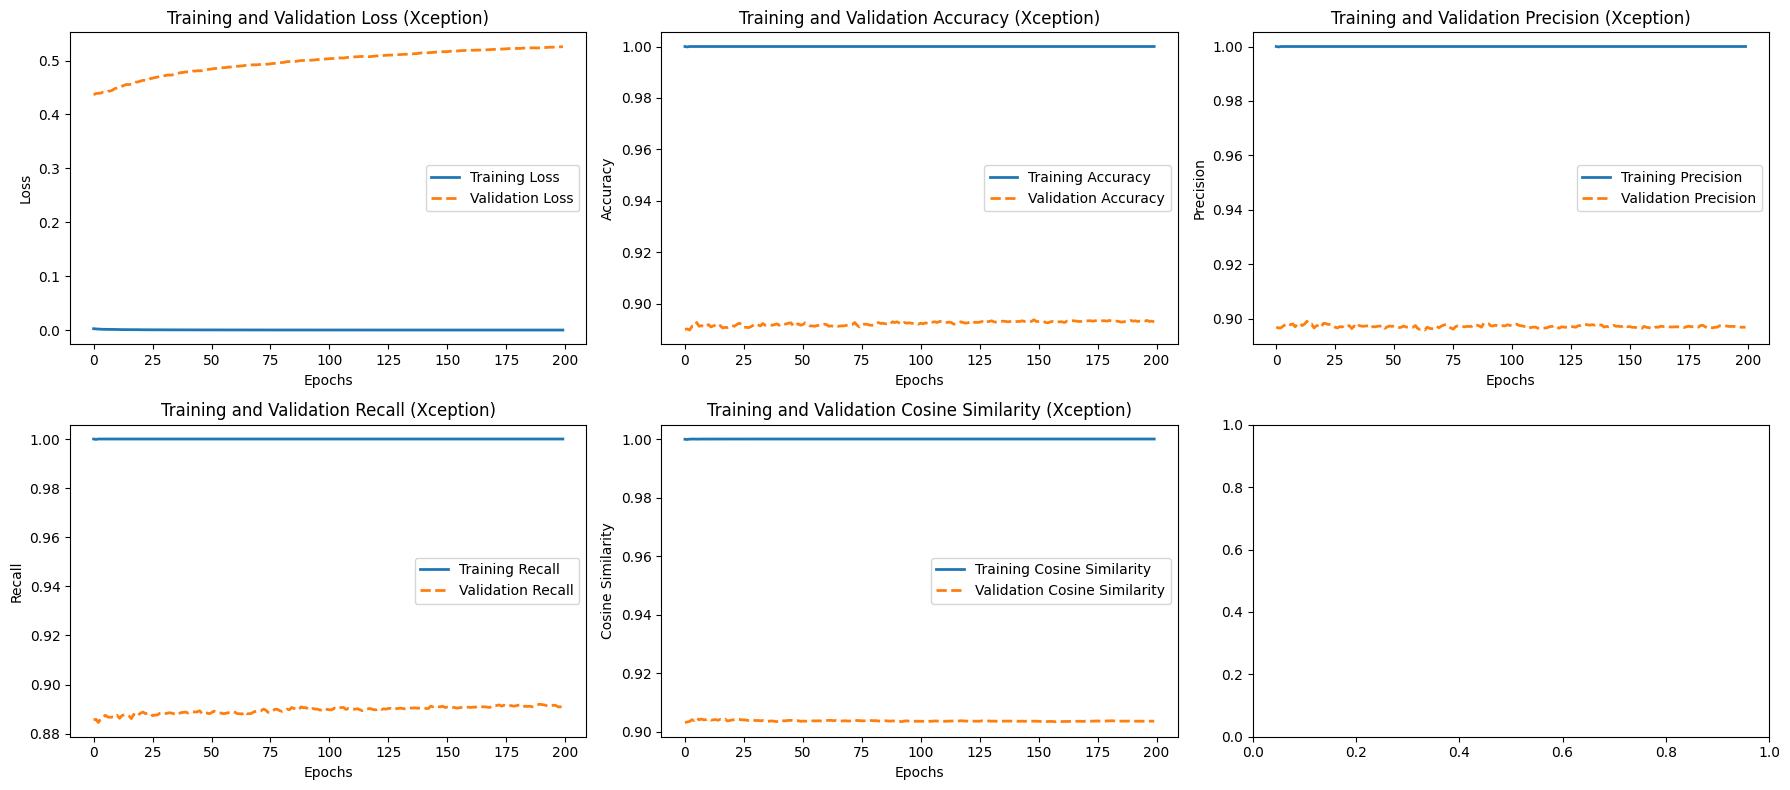

In [ ]:
import matplotlib.pyplot as plt

# Create a single figure for all subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Plot training and validation loss
axes[0, 0].plot(xception_train_losses, label='Training Loss', linestyle='-', linewidth=2)
axes[0, 0].plot(xception_val_losses, label='Validation Loss', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training and Validation Loss (Xception)')

# Plot training and validation accuracy
axes[0, 1].plot(xception_train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
axes[0, 1].plot(xception_val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Training and Validation Accuracy (Xception)')

# Plot precision, recall, and cosine similarity
axes[0, 2].plot(xception_train_precisions, label='Training Precision', linestyle='-', linewidth=2)
axes[0, 2].plot(xception_val_precisions, label='Validation Precision', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Training and Validation Precision (Xception)')

axes[1, 0].plot(xception_train_recalls, label='Training Recall', linestyle='-', linewidth=2)
axes[1, 0].plot(xception_val_recalls, label='Validation Recall', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Training and Validation Recall (Xception)')

axes[1, 1].plot(xception_train_cosine_similarity, label='Training Cosine Similarity', linestyle='-', linewidth=2)
axes[1, 1].plot(xception_val_cosine_similarity, label='Validation Cosine Similarity', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].legend()
axes[1, 1].set_title('Training and Validation Cosine Similarity (Xception)')

# Ensure that the layout is tight
plt.tight_layout()

plt.show()

In [ ]:
import os

# Define the directory path where you want to save the models
#path = "50K" #Initial
#path = "50K_Cost_sensitive" #Initial
path = "25K" #Augmented

# Ensure that the directory path exists, or create it if it doesn't
if not os.path.exists(path):
    os.makedirs(path)

# Evaluate the model
evaluation_results = cnn.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
cnn.save(f"{path}/cnn.h5")
print("Model saved to", f"{path}/cnn.h5")

# Evaluate the model
evaluation_results = resnet.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
resnet.save(f"{path}/resnet.h5")
print("Model saved to", f"{path}/resnet.h5")

# Evaluate the model
evaluation_results = vgg.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
vgg.save(f"{path}/vgg.h5")
print("Model saved to", f"{path}/vgg.h5")

# Evaluate the model
evaluation_results = xception.evaluate(test_ds, batch_size=32)
print("Evaluation results:", evaluation_results)
# Save the trained model to a file
xception.save(f"{path}/xception.h5")
print("Model saved to", f"{path}/xception.h5")


118/118 [==============================] - 1s 6ms/step - loss: 0.2023 - categorical_accuracy: 0.9527 - top_5_categorical_accuracy: 1.0000 - precision: 0.9562 - recall: 0.9493 - cosine_similarity: 0.9571
Evaluation results: [0.2022656351327896, 0.9526666402816772, 1.0, 0.9562181234359741, 0.9493333101272583, 0.9570580720901489]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to 25K/cnn.h5
118/118 [==============================] - 10s 86ms/step - loss: 0.2130 - categorical_accuracy: 0.9516 - top_5_categorical_accuracy: 1.0000 - precision: 0.9545 - recall: 0.9507 - cosine_similarity: 0.9568
Evaluation results: [0.21295388042926788, 0.9516000151634216, 1.0, 0.9544845819473267, 0.9506666660308838, 0.9567915201187134]
Model saved to 25K/resnet.h5
118/118 [==============================] - 5s 46ms/step - loss: 0.2979 - categorical_accuracy: 0.9431 - top_5_categorical_accuracy: 1.0000 - precision: 0.9447 - recall: 0.9423 - cosine_similarity: 0.9479
Evaluation results: [0.2979315221309662, 0.9430666565895081, 1.0, 0.9446598291397095, 0.9422666430473328, 0.9478960037231445]
Model saved to 25K/vgg.h5
118/118 [==============================] - 4s 36ms/step - loss: 0.4411 - categorical_accuracy: 0.8957 - top_5_categorical_accuracy: 1.0000 - precision: 0.9020 - recall: 0.8925 - cosine_similarity: 0.9068
Evaluation results: [0.4411166310310364, 0.8957333564

118/118 [==============================] - 0s 4ms/step


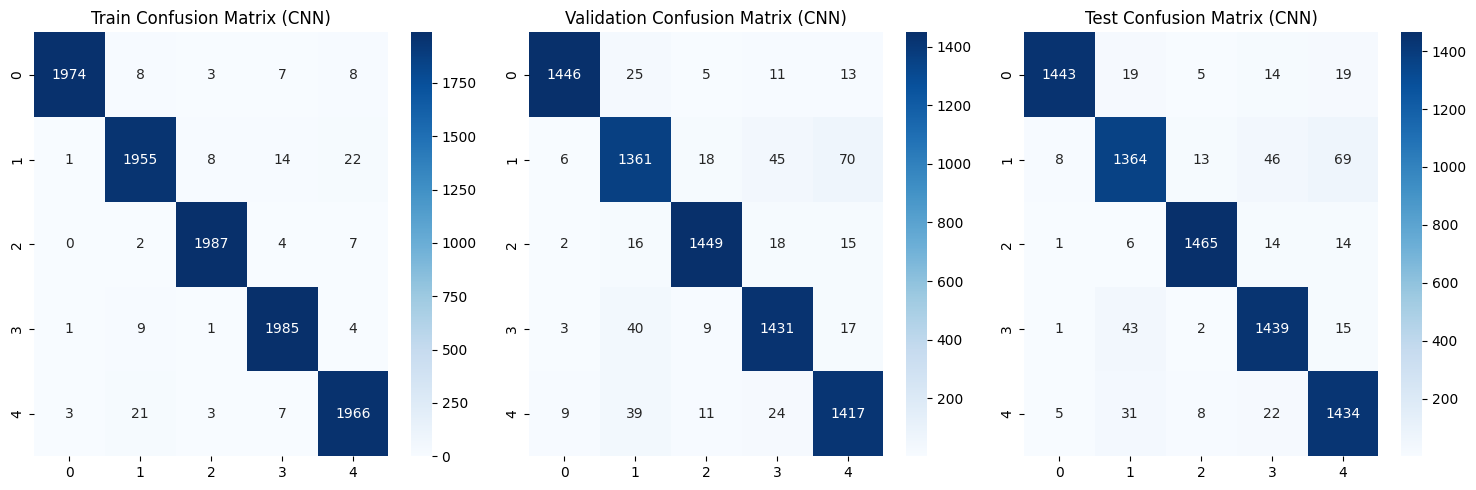

In [38]:
# Generate predictions for train, validation, and test datasets
train_predictions = cnn.predict(train_ds)
val_predictions = cnn.predict(val_ds)
test_predictions = cnn.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (CNN)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (CNN)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (CNN)')

plt.tight_layout()
plt.show()

118/118 [==============================] - 9s 80ms/step


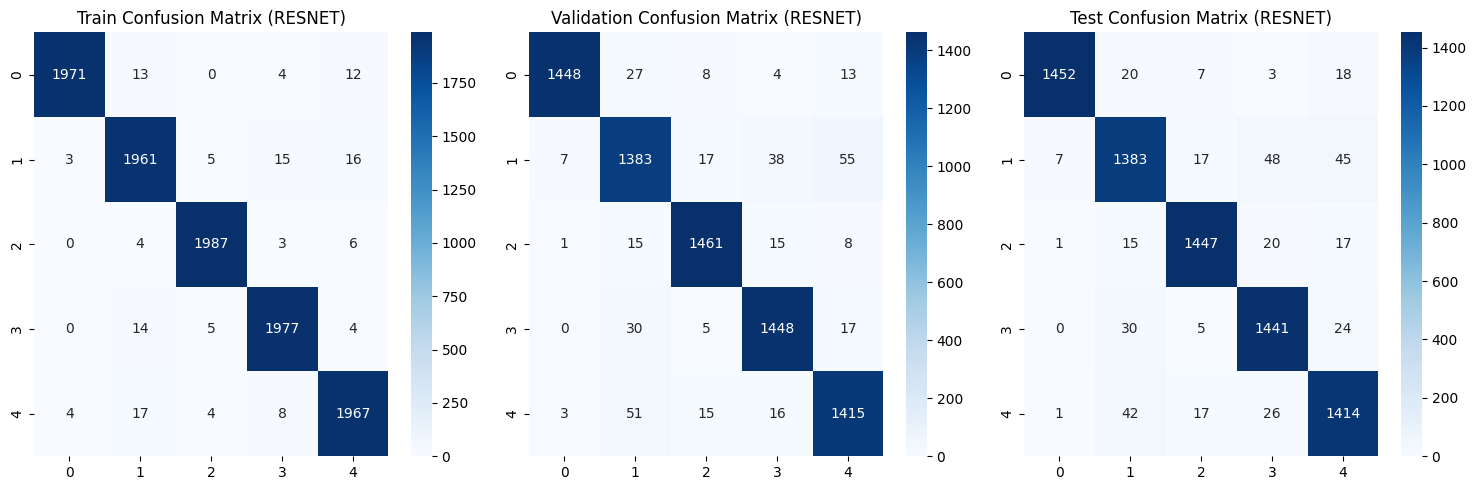

In [39]:
# Generate predictions for train, validation, and test datasets
train_predictions = resnet.predict(train_ds)
val_predictions = resnet.predict(val_ds)
test_predictions = resnet.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (RESNET)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (RESNET)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (RESNET)')

plt.tight_layout()
plt.show()

118/118 [==============================] - 5s 43ms/step


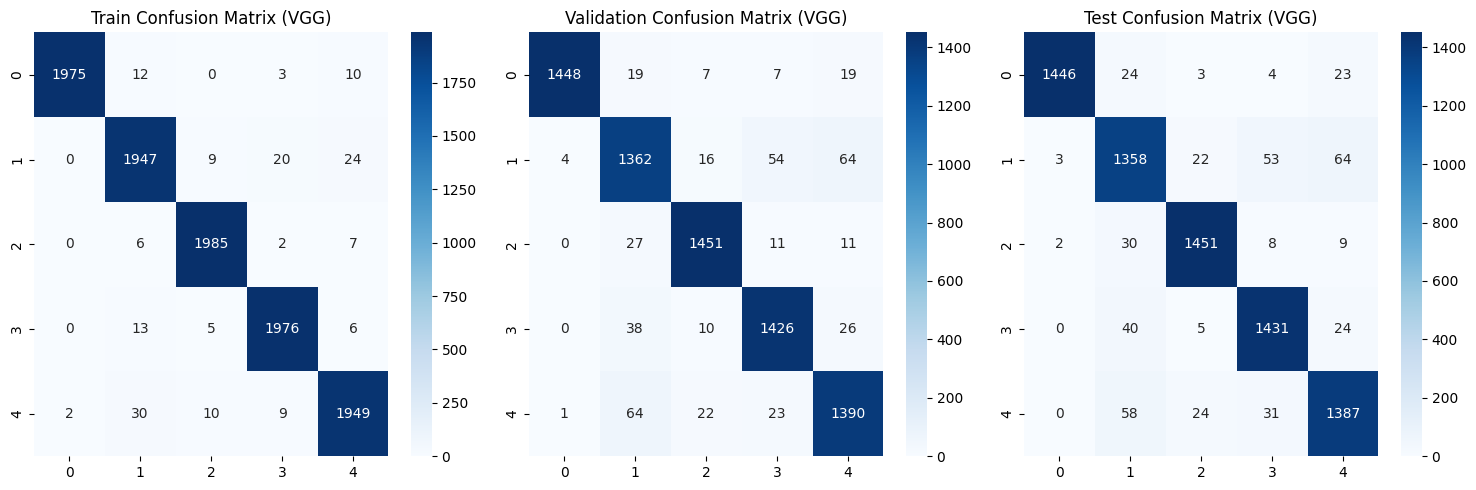

In [40]:
# Generate predictions for train, validation, and test datasets
train_predictions = vgg.predict(train_ds)
val_predictions = vgg.predict(val_ds)
test_predictions = vgg.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (VGG)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (VGG)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (VGG)')

plt.tight_layout()
plt.show()

118/118 [==============================] - 4s 34ms/step


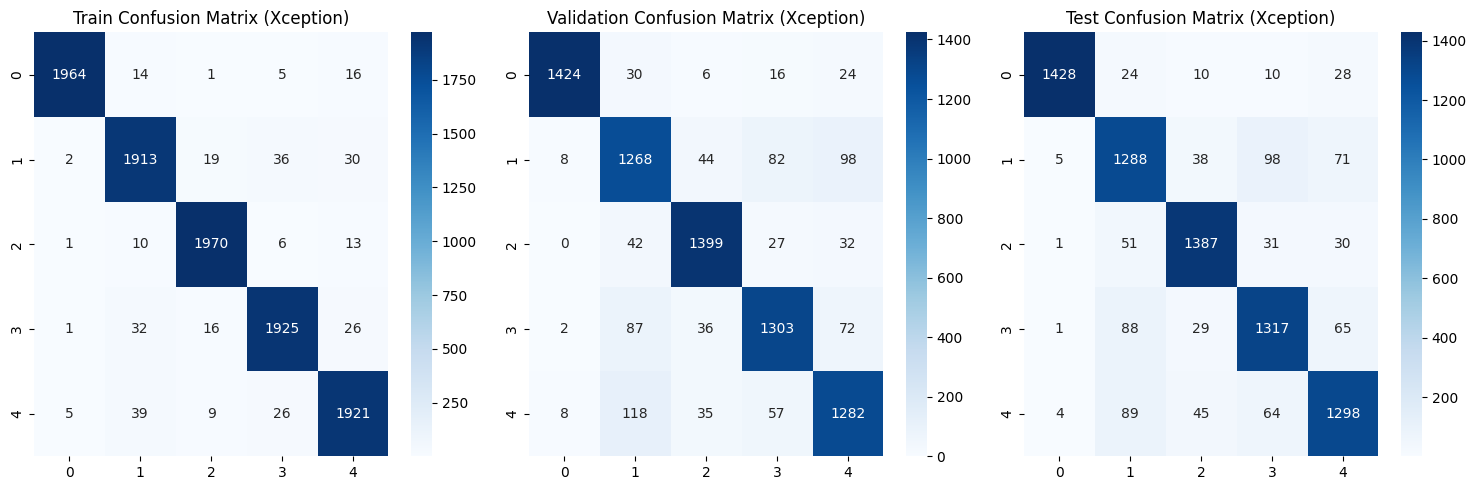

In [41]:
# Generate predictions for train, validation, and test datasets
train_predictions = xception.predict(train_ds)
val_predictions = xception.predict(val_ds)
test_predictions = xception.predict(test_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels for training, validation, and test datasets
train_true_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)
test_true_labels = np.concatenate([y for _, y in test_ds], axis=0)

# Convert one-hot encoded labels to integer labels
train_true_labels = np.argmax(train_true_labels, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)
test_true_labels = np.argmax(test_true_labels, axis=1)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
val_conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
test_conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix (Xception)')

plt.subplot(1, 3, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (Xception)')

plt.subplot(1, 3, 3)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix (Xception)')

plt.tight_layout()
plt.show()

In [42]:
#pip install shap

In [43]:
'''
import shap
import matplotlib.pyplot as plt

# Choose an image from the test dataset
image_index = 0  # Change this to the index of the image you want to explain

# Extract the specific image and label using a loop
for i, (image, label) in enumerate(test_ds):
    if i == image_index:
        chosen_image = image
        chosen_label = label
        break

# Create a SHAP explainer with a higher max_evals value
num_features = 300 * 300 * 3  # Number of features in your image
max_evals = 2 * num_features + 1  # Minimum required value
explainer = shap.Explainer(cnn, test_ds.map(lambda x, y: x), max_evals=max_evals)

# Calculate SHAP values for the chosen image
shap_values = explainer(chosen_image)

# Choose the class you want to explain (e.g., class 0)
class_to_explain = 0

# Get the expected value (baseline) for the model's output
expected_value = explainer.expected_value[class_to_explain]

# Plot the SHAP values as an overlay on the image
shap.image_plot(shap_values[class_to_explain], chosen_image.numpy(), show=False)
# Add a title to the plot
plt.title(f'SHAP Explanation for Class {class_to_explain}, Expected Value: {expected_value:.2f}')
# Show the plot
plt.show()
'''

"\nimport shap\nimport matplotlib.pyplot as plt\n\n# Choose an image from the test dataset\nimage_index = 0  # Change this to the index of the image you want to explain\n\n# Extract the specific image and label using a loop\nfor i, (image, label) in enumerate(test_ds):\n    if i == image_index:\n        chosen_image = image\n        chosen_label = label\n        break\n\n# Create a SHAP explainer with a higher max_evals value\nnum_features = 300 * 300 * 3  # Number of features in your image\nmax_evals = 2 * num_features + 1  # Minimum required value\nexplainer = shap.Explainer(cnn, test_ds.map(lambda x, y: x), max_evals=max_evals)\n\n# Calculate SHAP values for the chosen image\nshap_values = explainer(chosen_image)\n\n# Choose the class you want to explain (e.g., class 0)\nclass_to_explain = 0\n\n# Get the expected value (baseline) for the model's output\nexpected_value = explainer.expected_value[class_to_explain]\n\n# Plot the SHAP values as an overlay on the image\nshap.image_plot(s